## Residential Solar Demand Rate Analysis

The following is a practice analysis of how switching to a more advantageous rate plan may impact the energy bill for a residence with a PV system with potential energy storage.

The data is a csv of hourly solar generation (DC) and home load (AC) as the basis to evaluate the following (note that solar generation and home load are not labelled):

### Billing calculation

Assume that this home is within SRP territory and is on the [Pilot Price Plan for Residential Demand Rate Service](https://www.srpnet.com/prices/pdfx/April2015/E-27p.pdf).

Describe the structure of this tariff and calculate the monthly and yearly billing costs for this customer prior to adding a solar system.

*This residential tariff appears to be composed of a monthly service charge, a montly demand charge and a monthly consumption charge.  Page three details the on-peak per kW charges (demand charges).  These are itemized along three tiers (below 3kW, 3-10kW and above 10kW).  Page four details the per kWh charges (consumption charges). For the per kWh charges, an on-peak and off peak range is provided.*

In [1]:
import os
import pandas as pd
import numpy as np

base_path = r"C:\Users\akwan\Google Drive\search\Data Science"
from_dir = r"Sunrun_SrDataScientist"
from_fn = r"Data_Science_Take_Home.csv"

from_fp = os.path.join(base_path, from_dir, from_fn)
energy_df = pd.read_csv(from_fp, header=0)
energy_df.head()


,Unnamed: 0,Month,Day,Hour,Year,Column A,Column B
0,0,1,1,0,2017,0.642568,0.0
1,1,1,1,1,2017,0.531166,0.0
2,2,1,1,2,2017,0.487432,0.0
3,3,1,1,3,2017,0.474219,0.0
4,4,1,1,4,2017,0.473199,0.0


*First, I'd like to determine which column (A or B) is the hourly solar generation and what is the home load.  I can do this by plotting one day.  I have been informed that the hourly solar generation is expressed as kWh DC and the home load is expressed as kWh AC.  I will plot one day's worth of column A and B.*

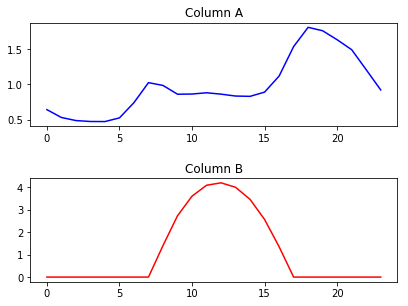

In [3]:
import matplotlib.pyplot as plt

day1_colA = energy_df['Column A'].iloc[0:24]
day1_colB = energy_df['Column B'].iloc[0:24]
day1_hours = energy_df['Hour'].iloc[0:24]

#print day1_hour

plt.figure(1)
plt.subplot(211)
plt.title("Column A")
plt.plot(day1_hours, day1_colA, 'b')

plt.subplot(212)
plt.title("Column B")
plt.plot(day1_hours, day1_colB, 'r')

plt.subplots_adjust(top=0.95, bottom=0.05, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.5)
plt.show()

*The plots for Column A shows a peak in the morning and a peak in the early afternoon.  This suggests that Column A represents the home load. The plot for Column B is an upside-down parabola that is typical of solar irradiation patterns.  This suggests that Column B represents the solar generation. I will relabel the columns accordingly.*

In [4]:
colnames = ['index', 'Month', 'Day', 'Hour', 'Year', 'home_load',
            'pv_gen']
energy_df.columns = colnames
print energy_df.columns

Index([u'index', u'Month', u'Day', u'Hour', u'Year', u'home_load', u'pv_gen'], dtype='object')


In [5]:
# set up the basic parameters of tariff
monthly_service_charge = 32.44 # value is in $

# consumption rate dictionary
# rates are in $ per kWh
c_rate_dict = {'summer':{'on':0.0486,'off':0.0371},
              'summerpeak':{'on':0.0633,'off':0.0423},
              'winter':{'on':0.0410,'off':0.0370}
              }

# demand rate dictionary
# demand rates:  element 0 corresponds to below 3kW, element 1 is the next 7kW, and element 2 is above 10kW
# rates are in $ per kW
d_rate_dict = {'summer':[8.03, 14.63, 27.77],
               'summerpeak':[9.59, 17.82, 34.19],
               'winter':[3.55, 5.68, 9.74]
               }

print d_rate_dict['summer'][0]


8.03


In [6]:
# set up seasons 
energy_df['season'] = np.nan
conditions = [energy_df['Month'].isin([5,6,9,10]),
              energy_df['Month'].isin([7,8]),
              energy_df['Month'].isin([1,2,3,4,11,12])]
choices = ['summer', 'summerpeak', 'winter']
energy_df['season'] = np.select(conditions, choices)



In [7]:
# create day of week column
import datetime

def getDayOfWeek(dfrow):
    yearval = dfrow['Year']
    monthval = dfrow['Month']
    dayval = dfrow['Day']
    dateval = datetime.datetime(yearval, monthval, dayval)
    return dateval.isoweekday()
# use isoweekday() where 1 is Monday and 7 is Sunday

energy_df['dayofweek'] = energy_df.apply(getDayOfWeek, axis=1)    

energy_df.head()


,index,Month,Day,Hour,Year,home_load,pv_gen,season,dayofweek
0,0,1,1,0,2017,0.642568,0.0,winter,7
1,1,1,1,1,2017,0.531166,0.0,winter,7
2,2,1,1,2,2017,0.487432,0.0,winter,7
3,3,1,1,3,2017,0.474219,0.0,winter,7
4,4,1,1,4,2017,0.473199,0.0,winter,7


In [46]:
# set up peak status
energy_df['peak'] = 'off' # the default is off peak
pk_conditions = [(energy_df['Month']==1) & (energy_df['Day']==1), # off peak for New Year's
                 (energy_df['Month']==5) & (energy_df['Day']==29), # off peak for Memorial Day
                 (energy_df['Month']==7) & (energy_df['Day']==4), # off peak for Independence Day
                 (energy_df['Month']==9) & (energy_df['Day']==4), # off peak for Labor Day
                 (energy_df['Month']==11) & (energy_df['Day']==23), # off peak for Thanksgiving
                 (energy_df['Month']==12) & (energy_df['Day']==25), # off peak for Christmas
                 energy_df['Month'].isin([5,6,7,8,9,10]) 
                 & energy_df['Hour'].isin([13,14,15,16,17,18,19]) 
                 & energy_df['dayofweek'].isin([1,2,3,4,5]),
                 energy_df['Month'].isin([1,2,3,4,11,12])
                 & energy_df['dayofweek'].isin([1,2,3,4,5])
                 & energy_df['Hour'].isin([5,6,7,8]),
                 energy_df['Month'].isin([1,2,3,4,11,12])
                 & energy_df['dayofweek'].isin([1,2,3,4,5])
                 & energy_df['Hour'].isin([17,18,19,20])]
pk_choices = ['off', 'off', 'off', 'off', 'off', 'off', 'on', 'on', 'on']
energy_df['peak'] = np.select(pk_conditions, pk_choices, default = 'off')


In [47]:
# set up consumption rate column
def getCRate(dfrow):
    seasonval = dfrow['season']
    peakval = dfrow['peak']
    return c_rate_dict[seasonval][peakval]

#print getCRate(energy_df.iloc[2,:])

energy_df['c_rate'] = energy_df.apply(getCRate, axis=1)
energy_df.head()

,index,Month,Day,Hour,Year,home_load,pv_gen,season,dayofweek,peak,c_rate,c_charge
0,0,1,1,0,2017,0.642568,0.0,winter,7,off,0.037,0.023775
1,1,1,1,1,2017,0.531166,0.0,winter,7,off,0.037,0.019653
2,2,1,1,2,2017,0.487432,0.0,winter,7,off,0.037,0.018035
3,3,1,1,3,2017,0.474219,0.0,winter,7,off,0.037,0.017546
4,4,1,1,4,2017,0.473199,0.0,winter,7,off,0.037,0.017508


In [48]:
# get the hourly consumption charge which is the home_load multiplied by the consumption rate, c_rate
energy_df['c_charge'] = energy_df['home_load']*energy_df['c_rate']
energy_df.head()

,index,Month,Day,Hour,Year,home_load,pv_gen,season,dayofweek,peak,c_rate,c_charge
0,0,1,1,0,2017,0.642568,0.0,winter,7,off,0.037,0.023775
1,1,1,1,1,2017,0.531166,0.0,winter,7,off,0.037,0.019653
2,2,1,1,2,2017,0.487432,0.0,winter,7,off,0.037,0.018035
3,3,1,1,3,2017,0.474219,0.0,winter,7,off,0.037,0.017546
4,4,1,1,4,2017,0.473199,0.0,winter,7,off,0.037,0.017508


In [41]:
# determine the peak demand per billing cycle (assuming billing cycle is month start to month end)
# according to the tariff document, on page 5, the "billing demand is the maximum 
# thirty-minute integrated kW demand occurring during the on-peak periods 
# of the billing cycle, as measured by the meter."
# The data in energy_df is only the home_load in kWh AC.
# So the estimate of the billing demand is 1/2 the maximum hourly kWh during
# on peak periods.  This is a reasonable but possibly big assumption.
month_peak = energy_df.groupby(['Month', 'peak', 'season'])
pdmd_df = pd.DataFrame(month_peak.agg(np.max)['home_load'])
pdmd_df.reset_index(inplace=True)
pdmd_df = pdmd_df[pdmd_df['peak']=='on']
pdmd_df['demand'] =  0.5 * pdmd_df['home_load']
pdmd_df

,Month,peak,season,home_load,demand
1,1,on,winter,1.802248,0.901124
3,2,on,winter,1.704291,0.852145
5,3,on,winter,1.863616,0.931808
7,4,on,winter,2.714235,1.357118
9,5,on,summer,4.231552,2.115776
11,6,on,summer,4.163406,2.081703
13,7,on,summerpeak,4.281637,2.140819
15,8,on,summerpeak,4.407195,2.203597
17,9,on,summer,4.336252,2.168126
19,10,on,summer,2.838743,1.419371


In [42]:
# determine demand charges

def demandCharge(dfrow):
    seasonval = dfrow['season']
    demandval = dfrow['demand']
    d_rate = d_rate_dict[seasonval]
    
    tiers = [3, 10]
    if demandval <= tiers[0]:
        d_charge = demandval*d_rate[0]
        #print('tier0')
    elif (demandval > tier[0]) & (demandval <= tiers[1]):
        d_charge = tiers[0]*d_rate[0] +  (demandval-tiers[0])*d_rate[1]
        #print('tier1')
    elif demandval > tier[1]:
        d_charge = (demandval-tiers[1])*d_rate[2] + (tiers[1]-tiers[0])*d_rate[1] + tiers[0]*d_rate[0]
        #print('tier1+')
    return d_charge
    #print d_rate
    #print d_charge
    
dtest = demandCharge(pdmd_df.iloc[1,:])
#print dtest

pdmd_df['d_charge'] = pdmd_df.apply(demandCharge, axis=1)
pdmd_df

,Month,peak,season,home_load,demand,d_charge
1,1,on,winter,1.802248,0.901124,3.198990
3,2,on,winter,1.704291,0.852145,3.025116
5,3,on,winter,1.863616,0.931808,3.307918
7,4,on,winter,2.714235,1.357118,4.817768
9,5,on,summer,4.231552,2.115776,16.989680
11,6,on,summer,4.163406,2.081703,16.716076
13,7,on,summerpeak,4.281637,2.140819,20.530451
15,8,on,summerpeak,4.407195,2.203597,21.132498
17,9,on,summer,4.336252,2.168126,17.410050
19,10,on,summer,2.838743,1.419371,11.397552


In [13]:
# now get monthly consumption charges along with monthly service charge to get monthly customer bill
month_grp = energy_df.groupby('Month')
month_df = pd.DataFrame(month_grp.agg(np.sum))
month_c_charge = pd.DataFrame(month_grp.agg(np.sum))['c_charge']
#print month_c_charge
#month_df
month_df = pdmd_df.copy()
month_df.set_index('Month', inplace=True)
month_df.reindex()
month_df['c_charge'] = month_c_charge
month_df['s_charge'] = monthly_service_charge
month_df['cust_bill'] = np.round((month_df.d_charge + month_df.c_charge + month_df.s_charge), decimals=2)
month_df.drop('peak', axis = 1, inplace=True)
month_df
#month_peak = energy_df.groupby(['Month', 'peak', 'season'])
#pdmd_df = pd.DataFrame(month_peak.agg(np.max)['home_load'])

,season,home_load,demand,d_charge,c_charge,s_charge,cust_bill
Month,,,,,,,
1,winter,1.802248,0.901124,3.198990,27.582940,32.44,63.22
2,winter,1.704291,0.852145,3.025116,24.262996,32.44,59.73
3,winter,1.863616,0.931808,3.307918,25.155962,32.44,60.90
4,winter,2.714235,1.357118,4.817768,27.346549,32.44,64.60
5,summer,4.231552,2.115776,16.989680,43.075833,32.44,92.51
6,summer,4.163406,2.081703,16.716076,57.159484,32.44,106.32
7,summerpeak,4.281637,2.140819,20.530451,86.896792,32.44,139.87
8,summerpeak,4.407195,2.203597,21.132498,83.825166,32.44,137.40
9,summer,4.336252,2.168126,17.410050,60.357283,32.44,110.21


In [14]:
# To get annual bill, we sum up monthly customer bill, cust_bill
annual_bill = month_df.cust_bill.sum()
print '${:,.2f}'.format(annual_bill)

$1,038.54



### Energy storage operation

Assume that this home has decided to add a solar system and an energy storage system to their home - specifically use the assumed generation of the solar system provided and assume a system with a [LG Chem RESU10](https://www.acsolarwarehouse.com/wp-content/uploads/2017/09/RESU10H_R_Data-sheet_ver1.0_170221.pdf) battery system and a [SolarEdge 7600A Inverter](https://www.solaredge.com/sites/default/files/se-single-phase-us-inverter-datasheet.pdf).

Provide Python code via a Jupyter Notebook that shows an algorithm for operation of the energy storage system that attempts to minimize customer bills on the above rate structure. Explain your algorithm, the trade-offs you decided on, improvements you would make in the future and a calculation of billing savings for adding the storage and solar system to this customer’s home along with your simulation.



*I will need to set up some parameters that capture the performance of the PV + battery system.  There will be some losses associated with storing the DC energy and then converting it to AC to supply the home load.  The maximum charge and discharge rate for the battery must be observed as well as the maximum capacity of the battery.  One strategy is to always charge the battery with the PV system during off peak periods and use it during on peak periods.  Another strategy which I believe the inverter is capable of is to charge the battery even when no PV generation is available during off peak periods and discharge during on peak periods.  I will attempt to model this scenario.  I want to first investigate a bit more how much energy is being used in the various seasons during on-peak vs. off-peak periods.*

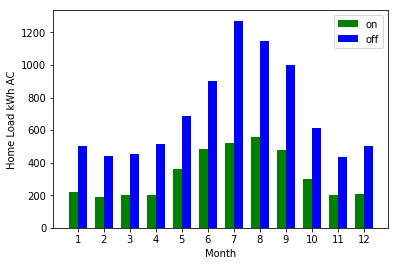

In [15]:
month_peak2 = energy_df.groupby(['Month', 'peak', 'season'])
pdmd_df2 = pd.DataFrame(month_peak2.agg(np.sum)['home_load'])
pdmd_df2.reset_index(inplace=True)

ind = np.arange(pdmd_df2.Month.max()) 
width = 0.35 

on_homeload = pdmd_df2[pdmd_df2['peak']=='on']['home_load']
#print on_homeload

off_homeload = pdmd_df2[pdmd_df2['peak']=='off']['home_load']
#print off_homeload

plt.bar(ind, on_homeload, width, color='green', label='on')
plt.bar(ind+width, off_homeload, width, color='blue', label='off')

plt.xlabel("Month")
plt.ylabel("Home Load kWh AC")

plt.xticks(ind + width / 2, ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'))
plt.legend(loc='best')
plt.show()

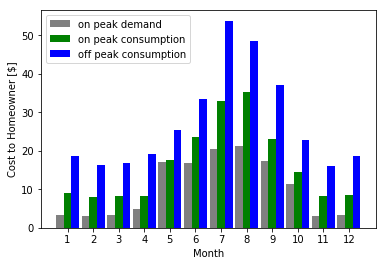

In [53]:
dmd_cspt_df = pd.DataFrame(month_peak2.agg(np.sum))
dmd_cspt_df.reset_index(inplace=True)
dmd_cspt_df
on_c_charge = dmd_cspt_df[dmd_cspt_df['peak']=='on']['c_charge']
off_c_charge = dmd_cspt_df[dmd_cspt_df['peak']=='off']['c_charge']
#print on_c_charge
#print off_c_charge

d_charge = pdmd_df['d_charge']
width2 = 0.3

plt.bar(ind, d_charge, width2, color='grey', label='on peak demand' )
plt.bar(ind+width2, on_c_charge, width2, color='green', label='on peak consumption')
plt.bar(ind+width2*2, off_c_charge, width2, color='blue', label='off peak consumption')
plt.xlabel("Month")
plt.ylabel("Cost to Homeowner [$]")

plt.xticks(ind + width2, ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'))
plt.legend(loc='best')
plt.show()

*Looking at bar chart above, it is noticeable that the off peak consumption costs contributes the most during each billing period.  That said, the on peak demand and on peak consumption charges bear a significant amount of the costs especially during summer and summer peak months.  This is likely due to the increased costs of energy during on peak periods.  One strategy to reduce costs is to use the PV + battery system to reduce or even negate on peak costs.*

In [211]:
# set up some parameters for the PV + storage system using the battery and inverter datasheets

batt_nrg_cap = 9.8 # This is the usable energy capacity in kWh
batt_nrg_use = 9.3 # This is the use-able energy in battery
batt_nrg_min = batt_nrg_cap - batt_nrg_use # minimum level of battery
batt_charge_rate_max = 5 # This is the maximum rate at which the battery should be charged/discharged
ac_dc_ratio = 8350./10250. # This is the conversion ratio between AC and DC for the system
inv_eff = 0.975 # This is the CEC rated efficiency of the inverter

print ac_dc_ratio

0.814634146341


In [59]:
energy_df['pv_gen_ac'] = energy_df['pv_gen'] * ac_dc_ratio * inv_eff
energy_df.head()

# assume that the battery
#for index, row in energy_df.iterrows():
#    print row['home_load']

,index,Month,Day,Hour,Year,home_load,pv_gen,season,dayofweek,peak,c_rate,c_charge,pv_gen_ac
0,0,1,1,0,2017,0.642568,0.0,winter,7,off,0.037,0.023775,0.0
1,1,1,1,1,2017,0.531166,0.0,winter,7,off,0.037,0.019653,0.0
2,2,1,1,2,2017,0.487432,0.0,winter,7,off,0.037,0.018035,0.0
3,3,1,1,3,2017,0.474219,0.0,winter,7,off,0.037,0.017546,0.0
4,4,1,1,4,2017,0.473199,0.0,winter,7,off,0.037,0.017508,0.0


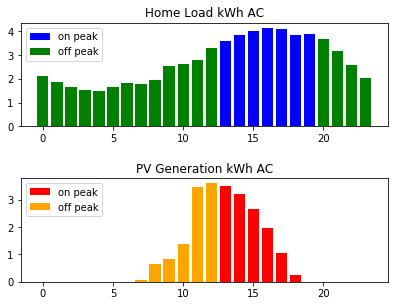

In [246]:
eval_month = 7
eval_day = 17

day_df = energy_df[(energy_df['Month']==eval_month) & (energy_df['Day']==eval_day)]
day_df

day_onpeak_df = day_df[day_df['peak']=='on']
day_offpeak_df = day_df[day_df['peak']=='off']

on_hours = day_onpeak_df['Hour']
on_home_load = day_onpeak_df['home_load']
on_pv_gen_ac = day_onpeak_df['pv_gen_ac']

off_hours = day_offpeak_df['Hour']
off_home_load = day_offpeak_df['home_load']
off_pv_gen_ac = day_offpeak_df['pv_gen_ac']

#art = 4429
#window = 100
#end = start + window
#energy_df.iloc[start:end,:]

width3 = 0.8
#plt.bar(ind, d_charge, width2, color='grey', label='on peak demand' )

plt.figure(1)
plt.subplot(211)
plt.title("Home Load kWh AC")
plt.bar(on_hours, on_home_load, width3, color='blue', label='on peak')
plt.bar(off_hours, off_home_load, width3, color='green', label='off peak')
plt.legend(['on peak', 'off peak'], loc='upper left')

plt.subplot(212)
plt.title("PV Generation kWh AC")
plt.bar(on_hours, on_pv_gen_ac, width3, color='red', label='on peak')
plt.bar(off_hours, off_pv_gen_ac, width3, color='orange', label='off peak')
plt.legend(['on peak', 'off peak'], loc='upper left')


plt.subplots_adjust(top=0.95, bottom=0.05, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.5)
#plt.show()


*I looked at a few different days in the above cell to get a better idea of how much generation occurs during winter, summer and summer peak periods as well as when the load and pv generation occurs with regard to on peak and off peak periods.  It allowed me to develop a strategy:*

*1.  For days where there are no on peak hours, an easy scheme would be to use the pv generation immediately.  If there is excess energy (difference between home load and pvgen + battery > 0), it would be stored in the battery until it is at its capacity.  Then when there is no pv generation, the battery would be used to off set the home load.*

In [243]:
def easyScheme(pvge, hle, bte):
    bae = bte - batt_nrg_min # available energy in battery
    #print bae
    gae = pvge + bae # available pv + battery energy
    #print gae
    dfe = hle - gae # difference between home load and gae 
    #print dfe
    # effective home load, efle, is whatever is bigger
    # zero or the difference between home load and gae
    efle = np.max([0, dfe]) 
    # if the difference between home load and gae is positive
    # then we use up all available battery so set
    # battery to batt_nrg_min - meaning we don't want to go
    # below minimum energy of battery
    if dfe > 0:
        btre = batt_nrg_min
    else:
        btre = np.min([batt_nrg_cap, (bte-dfe)])
    return btre, efle

#r1 = easyScheme(2, 3, batt_nrg_min)
#print "batt = " + str(r1[0]) + " effload = " + (str(r1[1]))

*2.  During the winter, the off peak periods coincides with most of the pv generation.  During the early morning period, it appears that only a small amount of pv generation occurs.  It would be beneficial to use the easyScheme scheme above. Then during the mid-day off peak period, prioritize charging the battery up to its capacity.  This will be the preCharge scheme below.  Finally, during the early evening on peak hours, use the battery and any pv generation to off set the home load and possibly reduce demand charges.  I would do this by a slow discharge.  It would be similar to the easyScheme but the most the battery would be reduced would be batt_nrg_cap divided by number of hours in the on peak period.  Reviewing the data for eval_month = 1 and eval_day = 10 provides a good example.*

In [240]:
def preCharge(pvgp, hlp, btp):
    bap = btp - batt_nrg_min # available energy in battery
    #print bap
    gap = pvgp + bap # available pv + battery energy
    #print gap
    dfp = hlp - gap # difference between home load and gae 
    #print dfp
    
    if dfp < 0:
        eflp = 0
        btrp = np.min([batt_nrg_cap, (pvgp-hlp+btp)])
    else:
        eflp = hlp - pvgp
        btrp = btp    
    return btrp, eflp
        

#r2 = preCharge(4, 3, 9)
#print "batt = " + str(r2[0]) + " effload = " + (str(r2[1]))
    

batt = 9.8 effload = 0


In [239]:
def slowDischarge(pvgs, hls, bts, maxds):
    #print maxds
    bas = bts - batt_nrg_min # available energy in battery
    #print bas
    gas = pvgs + bas # available pv + battery energy
    #print gas
    dfs = hls - gas
    #print dfs
    
    if dfs < 0:
        elfs = 0
        if pvgs > hls:
            #print "pvgs > hls"
            btrs = np.min([batt_nrg_cap, (pvgs-hls+bts)]) 
        else:
            if -dfs > maxds:
                #print -dfs
                #print "dfs > maxds"
                btrs = bts - maxds
            else:
                #print "dfs < maxds"
                btrs = np.max([batt_nrg_min, (gas-hls)])
    else:
        #print "dfs > 0 .... " + str(dfs)
        if bas > maxds:
            #print "bas > maxds ... " + str(bas)
            btrs = bts - maxds
            elfs = hls - pvgs - maxds
        else:
            #print "bas <= maxds ... " + str(hls-gas)
            btrs = batt_nrg_min
            elfs = hls - gas
    return btrs, elfs

#r3 = slowDischarge(1, 5, 2+0.5, (batt_nrg_use/4))
#print "batt = " + str(r3[0]) + " effload = " + (str(r3[1]))
   

*3.  During the summer and summer peak periods, the on peak period (in the afternoon) coincides with about half of the pv generation.  In the hours before 8pm, the strategy would be to use the pv generation to off set the home load .  Any excess pv generation would be used to charge the battery (the easy scheme detailed above).  After pv generation ends with sunset, the scheme would go back to the slow discharge scheme.  The discharge would be equivalent to the max battery energy capacity divided by the 4 hours in the afternoon. This would be to preserve the battery use in hot weather and to ensure home load reduction during on peak periods whidh would reduce the deamand charges. Reviewing the data for eval_month = 7 and eval_day = 17 provides a good example.*

In [262]:
batt_lvl = []
eff_home_load = []


#e_df = energy_df.iloc[24:47,:]
e_df = energy_df

batnrg = batt_nrg_min
effload = e_df.home_load.iloc[0]


for index, row in e_df.iterrows():
    hr = row['Hour']
    mn = row['Month']
    dy = row['Day']
    ssn = row['season']
    pvgenac = row['pv_gen_ac']
    homeload = row['home_load']
    
    #print str(mn) + " " + str(dy) + " " + str(hr) + " " + str(pvgenac) + " " + str(homeload)
    
       
    if ('on' in peak_info):  # the day has on peak periods
        if ssn == 'winter':
            if hr < 9:
                bb, ee = easyScheme(pvgenac, homeload, batnrg)
            elif (hr >= 9) & (hr < 17):
                bb, ee = preCharge(pvgenac, homeload, batnrg)
            elif (hr >= 17):
                bb, ee = slowDischarge(pvgenac, 
                                       homeload, 
                                       batnrg, 
                                       (batt_nrg_use / 4))
        else: # summer or summer peak
            if hr <= 20:
                bb, ee = easyScheme(pvgenac, homeload, batnrg)
            elif (hr > 20):
                bb, ee = slowDischarge(pvgenac, 
                                       homeload,
                                       batnrg,
                                       (batt_nrg_use / 4))
        batnrg = bb
        effload = ee
    else: # the day does not have on peak periods
        bb, ee = easyScheme(pvgenac, homeload, batnrg)
        batnrg = bb
        effload = ee

    #print "batnrg = " + str(batnrg)
    #print "effload = " + str(effload)
    batt_lvl.append(batnrg)
    eff_home_load.append(effload)        
            
            
            
            
#print batt_lvl    
#print eff_home_load
        
    
print len(batt_lvl)
print len(eff_home_load)
print energy_df.shape

energy_df['eff_home_load'] = eff_home_load
energy_df['batt_lvl'] = batt_lvl

energy_df.head()

8760
8760
(8760, 15)


,index,Month,Day,Hour,Year,home_load,pv_gen,season,dayofweek,peak,c_rate,c_charge,pv_gen_ac,eff_home_load,batt_lvl
0,0,1,1,0,2017,0.642568,0.0,winter,7,off,0.037,0.023775,0.0,0.642568,0.5
1,1,1,1,1,2017,0.531166,0.0,winter,7,off,0.037,0.019653,0.0,0.531166,0.5
2,2,1,1,2,2017,0.487432,0.0,winter,7,off,0.037,0.018035,0.0,0.487432,0.5
3,3,1,1,3,2017,0.474219,0.0,winter,7,off,0.037,0.017546,0.0,0.474219,0.5
4,4,1,1,4,2017,0.473199,0.0,winter,7,off,0.037,0.017508,0.0,0.473199,0.5


*Now calculate demand charges but this time use the 'eff_home_load', the effective home load.*

In [264]:
month_peak = energy_df.groupby(['Month', 'peak', 'season'])
pdmde_df = pd.DataFrame(month_peak.agg(np.max)['eff_home_load'])
pdmde_df.reset_index(inplace=True)
pdmde_df = pdmde_df[pdmde_df['peak']=='on']
pdmde_df['demand'] =  0.5 * pdmde_df['eff_home_load']
pdmde_df['d_charge'] = pdmde_df.apply(demandCharge, axis=1)
pdmde_df

,Month,peak,season,eff_home_load,demand,d_charge
1,1,on,winter,1.600128,0.800064,2.840227
3,2,on,winter,1.685812,0.842906,2.992316
5,3,on,winter,1.863616,0.931808,3.307918
7,4,on,winter,1.516817,0.758408,2.692350
9,5,on,summer,0.000000,0.000000,0.000000
11,6,on,summer,0.000000,0.000000,0.000000
13,7,on,summerpeak,0.000000,0.000000,0.000000
15,8,on,summerpeak,0.000000,0.000000,0.000000
17,9,on,summer,0.000000,0.000000,0.000000
19,10,on,summer,0.000000,0.000000,0.000000


In [278]:
energy_df['ce_charge'] = energy_df['eff_home_load']*energy_df['c_rate']
energy_df.head()
monthe_grp = energy_df.groupby('Month')
monthe_df = pd.DataFrame(monthe_grp.agg(np.sum))
monthe_ce_charge = pd.DataFrame(monthe_grp.agg(np.sum))['ce_charge']
monthe_df
monthe_df = pdmde_df.copy()
monthe_df.set_index('Month', inplace=True)
monthe_df.reindex()
monthe_df['ce_charge'] = monthe_ce_charge
monthe_df['s_charge'] = monthly_service_charge
monthe_df['cust_bill'] = np.round((monthe_df.d_charge + monthe_df.ce_charge + monthe_df.s_charge), decimals=2)
monthe_df.drop('peak', axis = 1, inplace=True)
monthe_df

,season,eff_home_load,demand,d_charge,ce_charge,s_charge,cust_bill
Month,,,,,,,
1,winter,1.600128,0.800064,2.840227,11.279248,32.44,46.56
2,winter,1.685812,0.842906,2.992316,9.655548,32.44,45.09
3,winter,1.863616,0.931808,3.307918,9.272698,32.44,45.02
4,winter,1.516817,0.758408,2.692350,8.547984,32.44,43.68
5,summer,0.000000,0.000000,0.000000,0.132564,32.44,32.57
6,summer,0.000000,0.000000,0.000000,0.000000,32.44,32.44
7,summerpeak,0.000000,0.000000,0.000000,3.739534,32.44,36.18
8,summerpeak,0.000000,0.000000,0.000000,2.008038,32.44,34.45
9,summer,0.000000,0.000000,0.000000,0.000000,32.44,32.44


In [279]:
annual_bill = monthe_df.cust_bill.sum()
print '${:,.2f}'.format(annual_bill)

$472.10


### Conclusion
*By implementing so different schemes during the seasons, I was able to reduce the bill from over * \$1000 *to less than* \$500*.  I used heuristic methods based on intuition built up from reviewing individual day profiles.  Given more time, I should be able employ linear (or nonlinear) programming optimization methods.  Testing the results with Monte Carlo simulations may be helpful.  All this work used several assumptions.  I would have to check them prior to doing more work.  There may be other charge/discharge schemes available.  My logic in developing the schemes need review.  This is a very interesting control problem.  Other considerations may include weather variability from year to year, comparing simulations to real world data of the PV + battery system (datasheets can be misleading), evaluation different schemes regarding the charge rate and depth of discharge of the batteries in light of real world operation.  Also the data used one hour increments.  There may be some hidden issues with building the simulation with that time scale.*


### Reference materials

Below are some resources that I reviewed to gain more contextual understanding for this project.
- https://energysmart.enelxnorthamerica.com/understanding-peak-demand-charges
- https://www.srpnet.com/prices/home/customergenerated.aspx
- https://www.solaredge.com/sites/default/files/inverter_dc_oversizing_guide.pdf